In [1]:
import numpy as np
import pandas as pd
# import h5py


# import pybel
# from tfbio.data import Featurizer

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [8]:
path = './PDBbind'

In [28]:
%%bash -s $path --out missing

path=$1

# Save binding affinities to csv file

echo 'pdbid,-logKd/Ki' > affinity_data.csv
cat $path/plain-text-index/index/INDEX_general_PL_data.2019 | while read l1 l2 l3 l4 l5; do
    if [[ ! $l1 =~ "#" ]]; then
        echo $l1,$l4
    fi
done >> affinity_data.csv

# Find affinities without structural data (i.e. with missing directories)

cut -f 1 -d ',' affinity_data.csv | tail -n +2 | while read l;
    do if [ ! -e $path/general/$l ] &&  [ ! -e $path/refined-set/$l ]; then
        echo $l;
    fi
done

In [2]:
with open('affinity_data.csv') as f:
    row = len(f.readlines())
    print(row)

17680


In [3]:
missing = set(missing.split())
len(missing)

NameError: name 'missing' is not defined

In [36]:
affinity_data = pd.read_csv('affinity_data.csv', comment='#')
affinity_data = affinity_data[~np.in1d(affinity_data['pdbid'], list(missing))]
affinity_data.shape

(17652, 2)

In [37]:
# Check for NaNs

affinity_data['-logKd/Ki'].isnull().any()

False

In [54]:
# Separate core, refined, and general sets
import os

# core_set = ! grep -v '#' $path/plain-text-index/index/INDEX_core_data.2019 | cut -f 1 -d ' '
# core_set = set(core_set)
core_set = set([f.name for f in os.scandir('./PDBbind/coreset') if f.is_dir()])
refined_set = set([f.name for f in os.scandir('./PDBbind/refined-set') if f.is_dir()])
general_set = set([f.name for f in os.scandir('./PDBbind/general') if f.is_dir()])


# assert core_set & refined_set == core_set
# assert refined_set & general_set == refined_set

len(general_set), len(refined_set), len(core_set)

(12800, 4854, 285)

In [55]:
affinity_data.loc[np.in1d(affinity_data['pdbid'], list(general_set)), 'set'] = 'general'

affinity_data.loc[np.in1d(affinity_data['pdbid'], list(refined_set)), 'set'] = 'refined'

affinity_data.loc[np.in1d(affinity_data['pdbid'], list(core_set)), 'set'] = 'core'

affinity_data.head()

,pdbid,-logKd/Ki,set
0,3zzf,0.40,general
1,3gww,0.45,general
2,1w8l,0.49,general
3,3fqa,0.49,general
4,1zsb,0.60,general


In [57]:
affinity_data.groupby('set').apply(len).loc[['general', 'refined', 'core']]

set
general    12781
refined     4586
core         285
dtype: int64

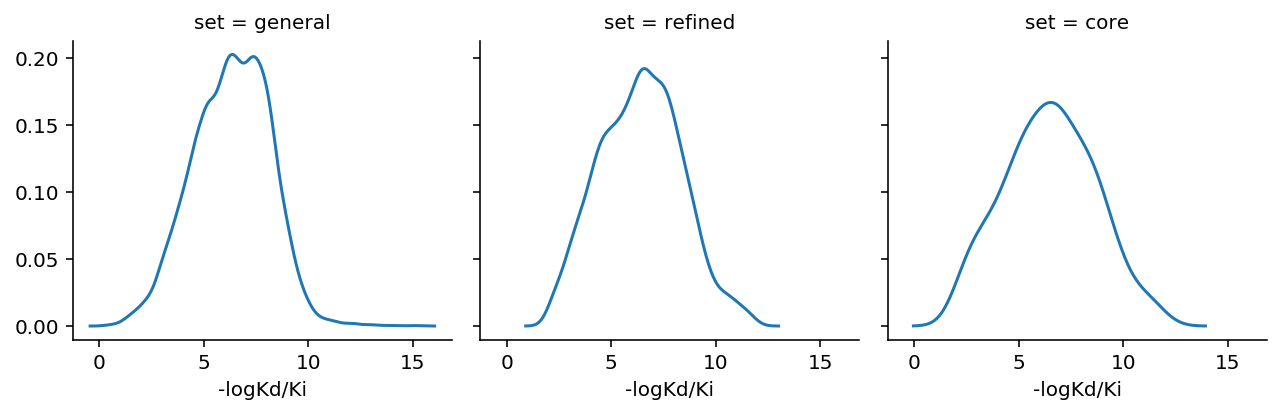

In [103]:
%config InlineBackend.figure_format='retina' 
# Check affinity distributions
g = sns.FacetGrid(affinity_data, col='set')
#grid.map(sns.displot, '-logKd/Ki', kind='kde');
g.map(sns.kdeplot, '-logKd/Ki')

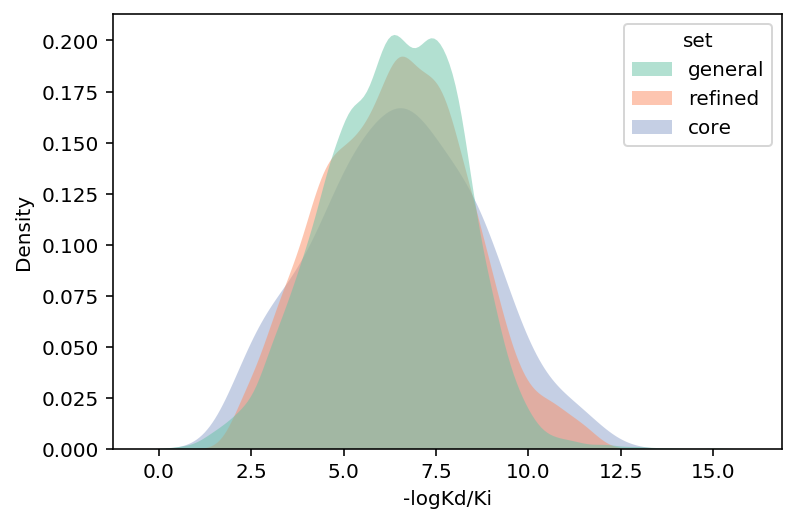

In [101]:
%config InlineBackend.figure_format='retina'
tips = sns.load_dataset("tips")
sns.kdeplot(
   data=affinity_data, x='-logKd/Ki', hue='set',
   fill=True, common_norm=False, palette="Set2",
   alpha=.5, linewidth=0,
)